Basic imports

In [2]:
#@title [RUN] Install required python libraries
import os

# Install PyTorch Geometric and other libraries
if 'IS_GRADESCOPE_ENV' not in os.environ:
    !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
    !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
    !pip install -q torch-geometric==2.0.3
    !pip install -q rdkit-pypi==2021.9.4
    !pip install -q py3Dmol==1.8.0

In [3]:
#@title [RUN] Import python modules

import os
import time
import random
import numpy as np

from scipy.stats import ortho_group

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.datasets import QM9
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.datasets import QM9
from torch_scatter import scatter

import rdkit.Chem as Chem
from rdkit.Geometry.rdGeometry import Point3D
from rdkit.Chem import QED, Crippen, rdMolDescriptors, rdmolops
from rdkit.Chem.Draw import IPythonConsole

import py3Dmol
from rdkit.Chem import AllChem

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#from google.colab import files
from IPython.display import HTML

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

PyTorch version 2.2.2
PyG version 2.0.3


In [4]:
#@title [RUN] Set random seed for deterministic results

def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)

Functions - may not need

In [5]:
#@title [RUN] Helper functions for data preparation

class SetTarget(object):
    """
    This transform mofifies the labels vector per data sample to only keep
    the label for a specific target (there are 19 targets in QM9).

    Note: for this practical, we have hardcoded the target to be target #0,
    i.e. the electric dipole moment of a drug-like molecule.
    (https://en.wikipedia.org/wiki/Electric_dipole_moment)
    """
    def __call__(self, data):
        target = 0 # we hardcoded choice of target
        data.y = data.y[:, target]
        return data


class CompleteGraph(object):
    """
    This transform adds all pairwise edges into the edge index per data sample,
    then removes self loops, i.e. it builds a fully connected or complete graph
    """
    
    # SK - is the point of this function adding bonds for atoms in a molecule that are not bonded?
    # SK - I seem to be lost in some details here, but may be it isn't important for now, feel free to ignore comments below
    
    def __call__(self, data):
        device = data.edge_index.device

        row = torch.arange(data.num_nodes, dtype=torch.long, device=device)
        col = torch.arange(data.num_nodes, dtype=torch.long, device=device)

        # SK - Docs on PyTorch view: https://pytorch.org/docs/stable/generated/torch.Tensor.view.html
        # SK - Step below is just creating 2D matrices for row and col
        row = row.view(-1, 1).repeat(1, data.num_nodes).view(-1)
        col = col.repeat(data.num_nodes)
        edge_index = torch.stack([row, col], dim=0)

        edge_attr = None
        if data.edge_attr is not None:
            # SK - seems that data.edge_attr is being stored within a subspace of edge_attr
            # SK - maybe this is necessary for the removal of self-loops ahead
            idx = data.edge_index[0] * data.num_nodes + data.edge_index[1]
            size = list(data.edge_attr.size())
            size[0] = data.num_nodes * data.num_nodes
            edge_attr = data.edge_attr.new_zeros(size)
            edge_attr[idx] = data.edge_attr

        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        data.edge_attr = edge_attr
        data.edge_index = edge_index

        return data

In [6]:
# For storing experimental results over the course of the practical
RESULTS = {}
DF_RESULTS = pd.DataFrame(columns=["Test MAE", "Val MAE", "Epoch", "Model"])

Convert networkx inputs to PyG

In [7]:
import json
import networkx as nx
import copy

def load_data_from_file(filename):
    """
    Load a dictionary of graphs from JSON file.
    """
    with open(filename, "r") as file_handle:
        string_dict = json.load(file_handle)
    return _load_data_from_string_dict(string_dict)

def load_data_from_string(json_string):
    """
    Load a dictionary of graphs from JSON string.
    """
    string_dict = json.loads(json_string)
    return _load_data_from_string_dict(string_dict)

def _load_data_from_string_dict(string_dict):
    result_dict = {}
    for key in string_dict:

        data = copy.deepcopy(string_dict[key])

        if 'edges' in data:
            data["links"] = data.pop("edges")

        graph = nx.node_link_graph(data)
        result_dict[key] = graph
    return result_dict

def write_data_to_json_string(graph_dict, **kwargs):
    """
    Write dictionary of graphs to JSON string.
    """
    json_string = json.dumps(graph_dict, default=nx.node_link_data, **kwargs)
    return json_string


def write_data_to_json_file(graph_dict, filename, **kwargs):
    """
    Write dictionary of graphs to JSON file.
    """
    with open(filename, "w") as file_handle:
        file_handle.write(write_data_to_json_string(graph_dict, **kwargs))

In [8]:
train_data = load_data_from_file("/Users/thepoetoftwilight/Documents/ML/gnn/ludwigteam/data/graph_data_duplicates_v2.json") # dictionary of SMILES and values are graphs

In [11]:
atom_dict = {
 'H':1,
 'He':2,
 'Li': 3,
 'B': 5,
 'C': 6,
 'N': 7,
 'O': 8,
 'F': 9,
 'Ne': 10,
 'Na': 11,
 'Mg': 12,
 'Al': 13,
 'Si': 14,
 'P': 15,
 'S': 16,
 'Cl': 17,
 'Ar': 18,
 'K': 19,
 'Ca': 20,
 'Ti': 22,
 'V': 23,
 'Cr': 24,
 'Mn': 25,
 'Fe': 26,
 'Co': 27,
 'Ni': 28,
 'Cu': 29,
 'Zn': 30,
 'Ga': 31,
 'Ge': 32,
 'As': 33,
 'Se': 34,
 'Br': 35,
 'Kr': 36,
 'Rb': 37,
 'Sr': 38,
 'Mo': 42,
 'Rh': 45,
 'Ag': 47,
 'Cd': 48,
 'In': 49,
 'Sn': 50,
 'Sb': 51,
 'Te': 52,
 'I': 53,
 'Xe': 54,
 'Cs': 55,
 'Ba': 56,
 'W': 74,
 'Re': 75,
 'Hg': 80,
 'Tl': 81,
 'Pb': 82,
 'Bi': 83,
 'U': 92
}

orb_dict = {
 '1s': [1, 0, 0],
 '2s': [2, 0, 0],
 '2p': [2, 1, 0],
 '2p3/2': [2, 1, 1.5],
    
 '3s': [3, 0, 0],
 '3p': [3, 1, 0],
 '3p3/2': [3, 1, 1.5],
 '3d': [3, 2, 0],
 '3d5/2': [3, 2, 2.5],
    
 '4s': [4, 0, 0],
 '4p3/2': [4, 1, 1.5],
 '4d': [4, 2, 0],
 '4d5/2': [4, 2, 2.5],
 '4f7/2': [4, 3, 3.5],
    
 '5s': [5, 0, 0],
 '5p3/2': [5, 1, 1.5],
 '5d5/2': [5, 2, 2.5],
}

orb_list = list(orb_dict.keys())

bond_dict = {'SINGLE':1, 'DOUBLE':2, 'TRIPLE':3, 'NONE':0}

In [14]:
dataset = []

for i,mol in enumerate(train_data):
    
    graph = train_data[mol]
    
    # Node info
    atom = list(nx.get_node_attributes(graph, "atom_type").values())
    charge = list(nx.get_node_attributes(graph, "formal_charge").values())
    orb = list(nx.get_node_attributes(graph, "orbitals").values())
    energy = list(nx.get_node_attributes(graph, "binding_energies").values())
    targets = list(nx.get_node_attributes(graph, "target").values())
    atom_index = targets.index(True)
    
    # Prepare dataset for this graph
    
    # Node feature shape (# atoms by target, atomic number, charge, one-hot encoding for orbital)
    x = np.zeros((len(atom), 20))
    # One global property for graph
    y = np.zeros(len(atom))
    
    x[:,0] = [atom_dict[a] for a in atom] # Indicate atomic numbers
    x[:,1] = charge
    
    x[atom_index,0] = 1 # Indicate target atom
    
    # One hot-encode orbital, double check
    x[atom_index, 3+orb_list.index(orb[atom_index][0])] = 1 
    
    y = energy[atom_index][0] # Global graph property
    
    # Encode edge indices
    edge_index = np.array(graph.edges).T
    # Edge info
    bond_types = list(nx.get_edge_attributes(graph, "bond_type").values())
    edge_attr = np.array([[bond_dict[b] for b in bond_types]]).T
    
    # Create PyGeometric graph
    pygraph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, name=mol)
    
    dataset.append(pygraph)

In [15]:
dataset[0]

Data(x=[1, 20], edge_index=[0], edge_attr=[0, 1], y=375.55, name='[Ag]_0_0')

In [16]:
len(dataset)

5192

## Data Preparation and Splitting

The QM9 dataset has over **130,000** molecular graphs!

Let us create a more tractable sub-set of **3,000** molecular graphs for the purposes of this practical and separate it into training, validation, and test sets. We shall use 1,000 graphs each for training, validation, and testing.

Towards the end of this practical, you will get to experiment with the full/larger sub-sets of the QM9 dataset, too.

In [7]:
print(f"Total number of samples: {len(dataset)}.")

# Split datasets (in case of using the full dataset)
# test_dataset = dataset[:10000]
# val_dataset = dataset[10000:20000]
# train_dataset = dataset[20000:]

# Split datasets (our 3K subset)
train_dataset = dataset[:1000]
val_dataset = dataset[1000:2000]
test_dataset = dataset[2000:3000]
print(f"Created dataset splits with {len(train_dataset)} training, {len(val_dataset)} validation, {len(test_dataset)} test samples.")

# Create dataloaders with batch size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Total number of samples: 130831.
Created dataset splits with 1000 training, 1000 validation, 1000 test samples.


In [8]:
train_dataset[0]

Data(x=[5, 11], edge_index=[2, 20], edge_attr=[20, 4], y=[1], pos=[5, 3], z=[5], name='gdb_1', idx=[1])

## Understanding PyG Data Objects

Each graph in our dataset is encapsulated in a PyG `Data` object, a convient way of representing all structured data for use in Geometric Deep Learning (including graphs, point clouds, and meshes).

In [14]:
data = train_dataset[0] # one data sample, i.e. molecular graph
print("Let us print all the attributes (along with their shapes) that our PyG molecular graph contains:")
print(data)

# SK - edge index has shape 2x number of edges because we need to describe (to, from) for each edge

Let us print all the attributes (along with their shapes) that our PyG molecular graph contains:
Data(x=[5, 11], edge_index=[2, 20], edge_attr=[20, 4], y=[1], pos=[5, 3], z=[5], name='gdb_1', idx=[1])


Within an instance of a `Data` object, individual `Torch.Tensor` attributes (or any other variable type) can be easily dot accessed within a neural network layer. The graphs from PyG come with a number of pre-computed features which we describe below (do not worry if you are unfamiliar with the chemistry terms here):

**Atom features (`data.x`)** - $\mathbb{R}^{|V| \times 11}$
- 1st-5th features: Atom type (one-hot: H, C, N, O, F)
- 6th feature (also `data.z`): Atomic number (number of protons).
- 7th feature: Aromatic (binary)
- 8th-10th features: Electron orbital hybridization (one-hot: sp, sp2, sp3)
- 11th feature: Number of hydrogens

**Edge Index (`data.edge_index`)** - $\mathbb{R}^{2×|E|}$
- A tensor of dimensions 2 x `num_edges` that describe the edge connectivity of the graph

**Edge features (`data.edge_attr`)** - $\mathbb{R}^{|E|\times 4}$
- 1st-4th features: bond type (one-hot: single, double, triple, aromatic)

**Atom positions (`data.pos`)** - $\mathbb{R}^{|V|\times 3}$
- 3D coordinates of each atom . (We will talk about their importance later in the practical.)

**Target (`data.y`)** - $\mathbb{R}^{1}$
- A scalar value corresponding to the molecules electric dipole moment

**❗️Note:** We will be using **fully-connected graphs** (i.e. all atoms in a molecule are connected to each other, except self-loops). The information about the molecule structures will be available to the models through the edge features (`data.edge_attr`) as follows:
- When two atoms are physically connected, the edge attributes indicate the **bond type** (single, double, triple, or aromatic) through a one-hot vector.
- When two atoms are not physically connected, **all edge attributes** are **zero**.
We will later study the advantages/downsides of fully-connected adjacency matrices versus sparse adjacency matrices (where an edge between two atoms is present only when there exists a physical connection between them).

In [15]:
print(f"\nThis molecule has {data.x.shape[0]} atoms, and {data.edge_attr.shape[0]} edges.")

print(f"\nFor each atom, we are given a feature vector with {data.x.shape[1]} entries (described above).")

print(f"\nFor each edge, we are given a feature vector with {data.edge_attr.shape[1]} entries (also described above).")

print(f"\nIn the next section, we will learn how to build a GNN in the Message Passing flavor to process the node and edge features of molecular graphs and predict their properties.")

print(f"\nEach atom also has a {data.pos.shape[1]}-dimensional coordinate associated with it. We will talk about their importance later in the practical.")

print(f"\nFinally, we have {data.y.shape[0]} regression target for the entire molecule.")


This molecule has 5 atoms, and 20 edges.

For each atom, we are given a feature vector with 11 entries (described above).

For each edge, we are given a feature vector with 4 entries (also described above).

In the next section, we will learn how to build a GNN in the Message Passing flavor to process the node and edge features of molecular graphs and predict their properties.

Each atom also has a 3-dimensional coordinate associated with it. We will talk about their importance later in the practical.

Finally, we have 1 regression target for the entire molecule.


# 📩 Part 0: Introduction to Message Passing Neural Networks in PyTorch Geometric

As a gentle introduction to PyTorch Geometric, we will walk you through the first steps of developing a GNN in the **Message Passing** flavor.

<!-- ![](https://drive.google.com/uc?id=1Wdgdq606XW1MelvcU1nW5CxWe1rHsWt1) -->
<img src="https://github.com/chaitjo/dump/raw/main/gnn-layers.png">

## Formalism

Firstly, let us formalise our molecular property prediction pipeline. (Our notation will mostly follow what has been introduced in the lectures, but we do make some different choices for variable names.)

### Graph
Consider a molecular graph $\mathcal{G} = \left( \mathcal{V}, \mathcal{E} \right)$, where $\mathcal{V}$ is a set of $n$ nodes, and $\mathcal{E}$ is a set of edges associated with the nodes. For each node $i \in \mathcal{V}$, we are given a $d_n$-dimensional initial feature vector $h_i \in \mathbb{R}^{d_n}$.
For each edge $(i, j) \in \mathcal{E}$, we are given a $d_e$-dimensional initial feature vector $e_{ij} \in \mathbb{R}^{d_e}$. For QM9 graphs, $d_n = 11, d_e = 4$.

### Label/target
Associated with each graph $\mathcal{G}$ is a scalar target or label $y \in \mathbb{R}^{1}$, which we would like to predict.

We will design a Message Passing Neural Network for graph property prediction to do this. Our MPNN will consist of several layers of message passing, followed by a global pooling and prediction head.

### MPNN Layer
The Message Passing operation iteratively updates node features $h_i^{\ell} \in \mathbb{R}^d$ from layer $\ell$ to layer $\ell+1$ via the following equation:
$$
h_i^{\ell+1} = \phi \Bigg( h_i^{\ell}, \oplus_{j \in \mathcal{N}_i} \Big( \psi \left( h_i^{\ell}, h_j^{\ell}, e_{ij} \right) \Big) \Bigg),
$$
where $\psi, \phi$ are Multi-Layer Perceptrons (MLPs), and $\oplus$ is a permutation-invariant local neighborhood aggregation function such as summation, maximization, or averaging.

Let us break down the MPNN layer into three pedagogical steps:
- **Step (1): Message.** For each pair of linked nodes $i, j$, the network first computes a message $m_{ij} =  \psi \left( h_i^{\ell}, h_j^{\ell}, e_{ij} \right)$. The MLP $\psi: \mathbb{R}^{2d + d_e} → \mathbb{R}^d$ takes as input the concatenation of the feature vectors from the source node, destination node, and edge.
    - Note that for the first layer $\ell=0$, $h_i^{\ell=0} = W_{in} \left( h_i \right)$, where $W_{in} \in \mathbb{R}^{d_n}  \rightarrow \mathbb{R}^{d}$ is a simple linear projection (`torch.nn.Linear`) for the initial node features to hidden dimension $d$.
- **Step (2): Aggregate.** At each node $i$, the incoming messages from all its neighbors are then aggregated as $m_{i} = \oplus_{{j \in \mathcal{N}_i}} \left( m_{ij} \right)$, where $\oplus$ is a permutation-invariant function. We will use summation, i.e. $\oplus_{{j \in \mathcal{N}_i}} = \sum_{{j \in \mathcal{N}_i}}$.
- **Step (3): Update.** Finally, the network updates the node feature vector $h_i^{\ell+1} = \phi \left( h_i^{\ell}, m_i \right)$, by concatenating the aggregated message $m_i$ and the previous node feature vector $h_i^{\ell}$, and passing them through an MLP $\phi: \mathbb{R}^{2d} → \mathbb{R}^{d}$.

### Global Pooling and Prediction Head
After $L$ layers of message passing, we obtain the final node features $h_i^{\ell=L}$. As we have a single target $y$ per graph, we must pool all node features into a single graph feature or graph embedding $h_G \in \mathbb{R}^d$ via another permutation-invariant function $R$, sometimes called the 'readout' function, as follows:
$$
h_G = R_{i \in \mathcal{V}} \left( h_i^{\ell=L} \right).
$$
We will use global average pooling over all node features, i.e.
$$
h_G = \frac{1}{|\mathcal{V}|} \sum_{i \in \mathcal{V}} h_i^{\ell=L}.
$$

The graph embedding $h_G$ is passed through a linear prediction head $W_{pred} \in \mathbb{R}^{d} \rightarrow \mathbb{R}^1$ to obtain the overall prediction $\hat y \in \mathbb{R}^1$:
$$
\hat y = W_{pred} \left( h_G \right).
$$

### Loss Function
Our MPNN graph property prediction model can be trained end-to-end via minimizing the standard mean-squared error loss for regression:
$$
\mathcal{L}_{MSE} = \lVert y - \hat y \rVert^2_2.
$$

## Coding the basic Message Passing Neural Network Layer

We are now ready to define a basic MPNN layer which implements what we have described above. In particular, we will code up the **MPNN Layer** first. (We will code up the other parts subsequently.)

To do so, we will inherit from the `MessagePassing` base class, which automatically takes care of message propagation and is extremely useful to develop advanced GNN models. To implement a custom MPNN, the user only needs to define the behaviour of the `message` (i.e. $\psi$), the `aggregate`(i.e. $\oplus$), and `update` (i.e. $\phi$) functions. You may also refer to the [PyG documentation](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html) for implementing custom message passing layers.

Below, we provide the implementation of a standard MPNN layer as an example, with extensive inline comments to help you figure out what is going on.

In [13]:
class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
        """Message Passing Neural Network Layer

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # MLP `\psi` for computing messages `m_ij`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: (2d + d_e) -> d
        self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: 2d -> d
        self.mlp_upd = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

    def forward(self, h, edge_index, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.

        As our MPNNLayer class inherits from the PyG MessagePassing parent class,
        we simply need to call the `propagate()` function which starts the
        message passing procedure: `message()` -> `aggregate()` -> `update()`.

        The MessagePassing class handles most of the logic for the implementation.
        To build custom GNNs, we only need to define our own `message()`,
        `aggregate()`, and `update()` functions (defined subsequently).

        Args:
            h: (n, d) - initial node features
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """
        out = self.propagate(edge_index, h=h, edge_attr=edge_attr)
        return out

    def message(self, h_i, h_j, edge_attr):
        """Step (1) Message

        The `message()` function constructs messages from source nodes j
        to destination nodes i for each edge (i, j) in `edge_index`.

        The arguments can be a bit tricky to understand: `message()` can take
        any arguments that were initially passed to `propagate`. Additionally,
        we can differentiate destination nodes and source nodes by appending
        `_i` or `_j` to the variable name, e.g. for the node features `h`, we
        can use `h_i` and `h_j`.

        This part is critical to understand as the `message()` function
        constructs messages for each edge in the graph. The indexing of the
        original node features `h` (or other node variables) is handled under
        the hood by PyG.

        Args:
            h_i: (e, d) - destination node features
            h_j: (e, d) - source node features
            edge_attr: (e, d_e) - edge features

        Returns:
            msg: (e, d) - messages `m_ij` passed through MLP `\psi`
        """
        # SK - note how the dimensions of h_i and h_j were recast compared to forward()
        msg = torch.cat([h_i, h_j, edge_attr], dim=-1)
        return self.mlp_msg(msg)

    def aggregate(self, inputs, index):
        """Step (2) Aggregate

        The `aggregate` function aggregates the messages from neighboring nodes,
        according to the chosen aggregation function ('sum' by default).

        Args:
            inputs: (e, d) - messages `m_ij` from destination to source nodes
            index: (e, 1) - list of source nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)

    def update(self, aggr_out, h):
        """
        Step (3) Update

        The `update()` function computes the final node features by combining the
        aggregated messages with the initial node features.

        `update()` takes the first argument `aggr_out`, the result of `aggregate()`,
        as well as any optional arguments that were initially passed to
        `propagate()`. E.g. in this case, we additionally pass `h`.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
        """
        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')

Great! We have defined a **Message Passing layer** following the equation we had introduced previously. Let us use this layer to code up the full **MPNN graph property prediction model**. This model will take as input molecular graphs, process them via multiple MPNN layers, and predict a single property for each of them.

In [14]:
class MPNNModel(Module):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()

        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = Linear(in_dim, emb_dim)

        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))

        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)

    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns:
            out: (batch_size, out_dim) - prediction for each graph
        """
        h = self.lin_in(data.x) # (n, d_n) -> (n, d)

        for conv in self.convs:
            h = h + conv(h, data.edge_index, data.edge_attr) # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

        return out.view(-1)

Awesome! We are done defining our first MPNN model for graph property prediction.

But wait! Before we dive into training and evaluation this model, let us write some sanity checks for a **fundamental property** of the model and the layer.

## Unit tests for Permutation Invariance and Equivariance

The lectures have repeatedly indicated on certain fundamental properties for machine learning on graphs:
- A **GNN <ins>layer**</ins> is **equivariant** to permutations of the set of nodes in the graph; i.e. as we permute the nodes, the node features produced by the GNN must permute accordingly.
- A **GNN <ins>model**</ins> for graph-level property prediction is **invariant** to the permutations of the set of nodes in the graph; i.e. as we permute the nodes, the graph-level propery remains unchanged.

(But wait...**What is a permutation?** Essentially, it is an **ordering of the nodes** in a graph. In general, there is **no canonical way** of assigning an ordering of the nodes, unlike textual or image data. However, graphs need to be stored and processed on computers in order to perform machine learning on them (which is what this course is about!). Thus, we need to ensure that our models are able to principaly handle this **lack of canonical ordering** or permutation of graph nodes. This is what the above statements are trying to say.)

### Formalism

Let us try to formalise these notions of permutation invariance and equivariance via matrix notation (it is easier that way).

- Let $\mathbf{H} \in \mathbb{R}^{n \times d}$ be a matrix of node features for a given molecular graph, where $n$ is the number of nodes/atoms and each row $h_i$ is the $d$-dimensional feature for node $i$.
- Let $\mathbf{A} \in \mathbb{R}^{n \times n}$ be the adjacency matrix where each entry denotes $a_{ij}$ the presence or absence of an edge between nodes $i$ and $j$.
- Let $\mathbf{F}(\mathbf{H}, \mathbf{A}): \mathbb{R}^{n \times d} \times \mathbb{R}^{n \times n} \rightarrow \mathbb{R}^{n \times d}$ be a **GNN <ins>layer**</ins> that takes as input the node features and adjacency matrix, and returns the **updated node features**.
- Let $f(\mathbf{H}, \mathbf{A}): \mathbb{R}^{n \times d} \times \mathbb{R}^{n \times n} \rightarrow \mathbb{R}$ be a **GNN <ins>model**</ins> that takes as input the node features and adjacency matrix, and returns the **predicted graph-level property**.
- Let $\mathbf{P} \in \mathbb{R}^{n \times n}$ be a **[permutation matrix](https://en.wikipedia.org/wiki/Permutation_matrix)** which has exactly one 1 in every row and column, and 0s elsewhere. Left-multipying $\mathbf{P}$ with a matrix changes the ordering of the rows of the matrix.

### Permuation Equivariance

The GNN <ins>layer</ins> $\mathbf{F}$ is **permuation equivariant** as follows:
$$
\mathbf{F}(\mathbf{PH}, \mathbf{PAP^T}) = \mathbf{P} \ \mathbf{F}(\mathbf{H}, \mathbf{A}).
$$

Another way to formulate the above could be: (1) Consider the updated node features $\mathbf{H'} = \mathbf{F}(\mathbf{H}, \mathbf{A})$. (2) Applying any permutation matrix $\mathbf{P}$ to the input of the GNN layer $\mathbf{F}$ should produce the same result as applying the same permutation on $\mathbf{H'}$:
$$
\mathbf{F}(\mathbf{PH}, \mathbf{PAP^T}) = \mathbf{P} \ \mathbf{H'}
$$

### Permuation Invariance

The GNN <ins>model</ins> $f$ for graph-level prediction is **permutation invariant** as follows:
$$
f(\mathbf{PH}, \mathbf{PAP^T}) = f(\mathbf{H}, \mathbf{A}).
$$

Another way to formulate the above could be: (1) Consider the predicted molecular property $\mathbf{\hat y} = f(\mathbf{H}, \mathbf{A})$. (2) Applying any permutation matrix $\mathbf{P}$ to the input of the GNN model $f$ should produce the same result as not applying it:
$$
f(\mathbf{PH}, \mathbf{PAP^T}) = \mathbf{\hat y}.
$$

With that formalism out of the way, let us write some unit tests to confirm that our `MPNNModel` and `MPNNLayer` are indeed permutation invariant and equivariant, respectively.

In [15]:
def permute_graph(data, perm):
    """Helper function for permuting PyG Data object attributes consistently.
    """
    # Permute the node attribute ordering
    data.x = data.x[perm]
    data.pos = data.pos[perm]
    data.z = data.z[perm]
    data.batch = data.batch[perm]

    # Permute the edge index
    adj = to_dense_adj(data.edge_index)
    adj = adj[:, perm, :]
    adj = adj[:, :, perm]
    data.edge_index = dense_to_sparse(adj)[0]

    # Note:
    # (1) While we originally defined the permutation matrix P as only having
    #     entries 0 and 1, its implementation via `perm` uses indexing into
    #     torch tensors, instead.
    # (2) It is cumbersome to permute the edge_attr, so we set it to constant
    #     dummy values. For any experiments beyond unit testing, all GNN models
    #     use the original edge_attr.

    return data

def permutation_invariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN model) is
    permutation invariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Set edge_attr to dummy values (for simplicity)
    data.edge_attr = torch.zeros(data.edge_attr.shape)

    # Forward pass on original example
    out_1 = module(data)

    # Create random permutation
    perm = torch.randperm(data.x.shape[0])
    data = permute_graph(data, perm)

    # Forward pass on permuted example
    out_2 = module(data)

    # Check whether output varies after applying transformations
    return torch.allclose(out_1, out_2, atol=1e-04)


def permutation_equivariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN layer) is
    permutation equivariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Set edge_attr to dummy values (for simplicity)
    data.edge_attr = torch.zeros(data.edge_attr.shape)

    # Forward pass on original example
    out_1 = module(data.x, data.edge_index, data.edge_attr)

    # Create random permutation
    perm = torch.randperm(data.x.shape[0])
    data = permute_graph(data, perm)

    # Forward pass on permuted example
    out_2 = module(data.x, data.edge_index, data.edge_attr)

    # Check whether output varies after applying transformations
    return torch.allclose(out_1[perm], out_2, atol=1e-04)

Now that we have defined the unit tests for permutation invariance (for the full MPNN model) and permutation equivariance (for the MPNN layer), let us perform the sanity check:

In [29]:
# Instantiate temporary model, layer, and dataloader for unit testing
layer = MPNNLayer(emb_dim=11, edge_dim=4)
model = MPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Permutation invariance unit test for MPNN model
print(f"Is {type(model).__name__} permutation invariant? --> {permutation_invariance_unit_test(model, dataloader)}!")

# Permutation equivariance unit for MPNN layer
print(f"Is {type(layer).__name__} permutation equivariant? --> {permutation_equivariance_unit_test(layer, dataloader)}!")

Is MPNNModel permutation invariant? --> True!
Is MPNNLayer permutation equivariant? --> True!


## Training and Evaluating Models

Great! We are finally ready to train and evaluate our model on QM9. We have provided a **basic experiment loop** which takes as input the model and dataloaders, performs training, and returns the final performance on the **validation** and **test set**.

We will be training a `MPNNModel` consisting of 4 layers of message passing with a hidden dimension of 64.

In [17]:
#@title [RUN] Helper functions for managing experiments, training, and evaluating models.

def train(model, train_loader, optimizer, device):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.mse_loss(y_pred, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)


def eval(model, loader, device):
    model.eval()
    error = 0

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data)
            # Mean Absolute Error using std (computed when preparing data)
            error += (y_pred * std - data.y * std).abs().sum().item()
    return error / len(loader.dataset)


def run_experiment(model, model_name, train_loader, val_loader, test_loader, n_epochs=100):

    print(f"Running experiment for {model_name}, training on {len(train_loader.dataset)} samples for {n_epochs} epochs.")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\nModel architecture:")
    print(model)
    total_param = 0
    for param in model.parameters():
        total_param += np.prod(list(param.data.size()))
    print(f'Total parameters: {total_param}')
    model = model.to(device)

    # Adam optimizer with LR 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # LR scheduler which decays LR when validation metric doesn't improve
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=5, min_lr=0.00001)

    print("\nStart training:")
    best_val_error = None
    perf_per_epoch = [] # Track Test/Val MAE vs. epoch (for plotting)
    t = time.time()
    for epoch in range(1, n_epochs+1):
        # Call LR scheduler at start of each epoch
        lr = scheduler.optimizer.param_groups[0]['lr']

        # Train model for one epoch, return avg. training loss
        loss = train(model, train_loader, optimizer, device)

        # Evaluate model on validation set
        val_error = eval(model, val_loader, device)

        if best_val_error is None or val_error <= best_val_error:
            # Evaluate model on test set if validation metric improves
            test_error = eval(model, test_loader, device)
            best_val_error = val_error

        if epoch % 10 == 0:
            # Print and track stats every 10 epochs
            print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss: {loss:.7f}, '
                  f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')

        scheduler.step(val_error)
        perf_per_epoch.append((test_error, val_error, epoch, model_name))

    t = time.time() - t
    train_time = t/60
    print(f"\nDone! Training took {train_time:.2f} mins. Best validation MAE: {best_val_error:.7f}, corresponding test MAE: {test_error:.7f}.")

    return best_val_error, test_error, train_time, perf_per_epoch

In [30]:
model = MPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model,
    model_name,
    train_loader,
    val_loader,
    test_loader,
    n_epochs=100
)
RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

Running experiment for MPNNModel, training on 1000 samples for 100 epochs.

Model architecture:
MPNNModel(
  (lin_in): Linear(in_features=11, out_features=64, bias=True)
  (convs): ModuleList(
    (0-3): 4 x MPNNLayer(emb_dim=64, aggr=add)
  )
  (lin_pred): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 103233

Start training:
Epoch: 010, LR: 0.001000, Loss: 0.5046814, Val MAE: 0.8734207, Test MAE: 0.7606434
Epoch: 020, LR: 0.001000, Loss: 0.4012593, Val MAE: 0.8558661, Test MAE: 0.6592537
Epoch: 030, LR: 0.000900, Loss: 0.3425880, Val MAE: 0.9920914, Test MAE: 0.6592537
Epoch: 040, LR: 0.000729, Loss: 0.2996923, Val MAE: 1.0544341, Test MAE: 0.6592537
Epoch: 050, LR: 0.000590, Loss: 0.2451063, Val MAE: 0.8585306, Test MAE: 0.6592537
Epoch: 060, LR: 0.000531, Loss: 0.2109724, Val MAE: 0.8556090, Test MAE: 0.6592537
Epoch: 070, LR: 0.000430, Loss: 0.1484727, Val MAE: 0.8526899, Test MAE: 0.6592537
Epoch: 080, LR: 0.000349, Loss: 0.1083980, Val MAE: 0.8565850, Test

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_53051/2825921790.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)


In [31]:
RESULTS

{'MPNNModel': (0.7902437596321106, 0.6579207420349121, 2.866050350666046)}

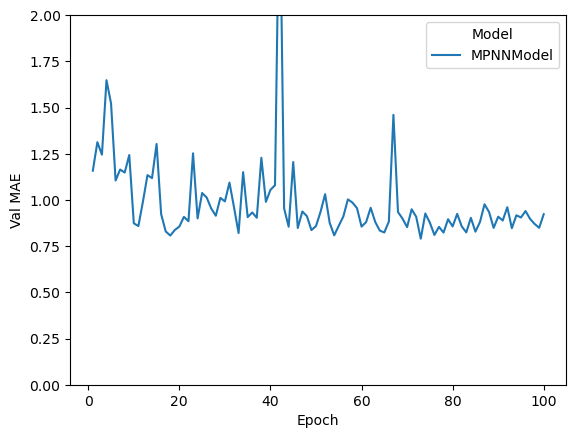

In [32]:
p = sns.lineplot(x="Epoch", y="Val MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 2));

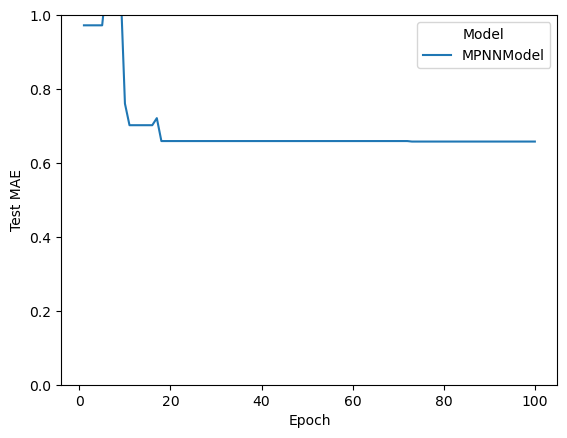

In [33]:
p = sns.lineplot(x="Epoch", y="Test MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 1));

Super! Everything up to this point has already been covered in the lectures, and we hope that the practical so far has been a useful recap along with the acompanying code.

Now for the fun part, where you will be required to think what you have studied so far!

---
---
---